# Data prep


In [0]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths
from sklearn.model_selection import train_test_split
from PIL import Image
import requests
import os
from collections import Counter

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras import models, layers, optimizers, utils, datasets, preprocessing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import resnet, vgg16, inception_v3
from keras.utils import to_categorical

tf.random.set_seed(17)

TensorFlow 2.x selected.


Using TensorFlow backend.


In [3]:
!git clone https://github.com/datawookie/cousteau.git
  
from cousteau.keras.plot import plot_history

Cloning into 'cousteau'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 18 (delta 6), reused 16 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [4]:
!rm -rf car-dataset # allows us to re-clone the dataset w/ updates and get the changes - if folder exists, clone does not work and we won't get anychanges
!git clone https://github.com/GerardWalsh/car-dataset.git

Cloning into 'car-dataset'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (486/486), done.
remote: Compressing objects: 100% (433/433), done.
remote: Total 486 (delta 81), reused 455 (delta 52), pack-reused 0
Receiving objects: 100% (486/486), 23.45 MiB | 26.74 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [0]:
image_paths = list(paths.list_images("car-dataset/train"))

images = []
labels = []

for path in image_paths:
  img = preprocessing.image.load_img(path, target_size=(224, 224))
  img = np.expand_dims(img, axis=0)
  
  images.append(img)

  label = path.split(os.path.sep)[-2]
  if label == "7_5":
    label = 0
  elif label == "7":
    label = 1
  elif label == '6':
    label = 2
  else: 
    label = 3
  labels.append(label)

In [6]:
Counter(labels).keys()

dict_keys([0, 3, 2, 1])

In [7]:
Counter(labels).values()

dict_values([61, 36, 85, 56])

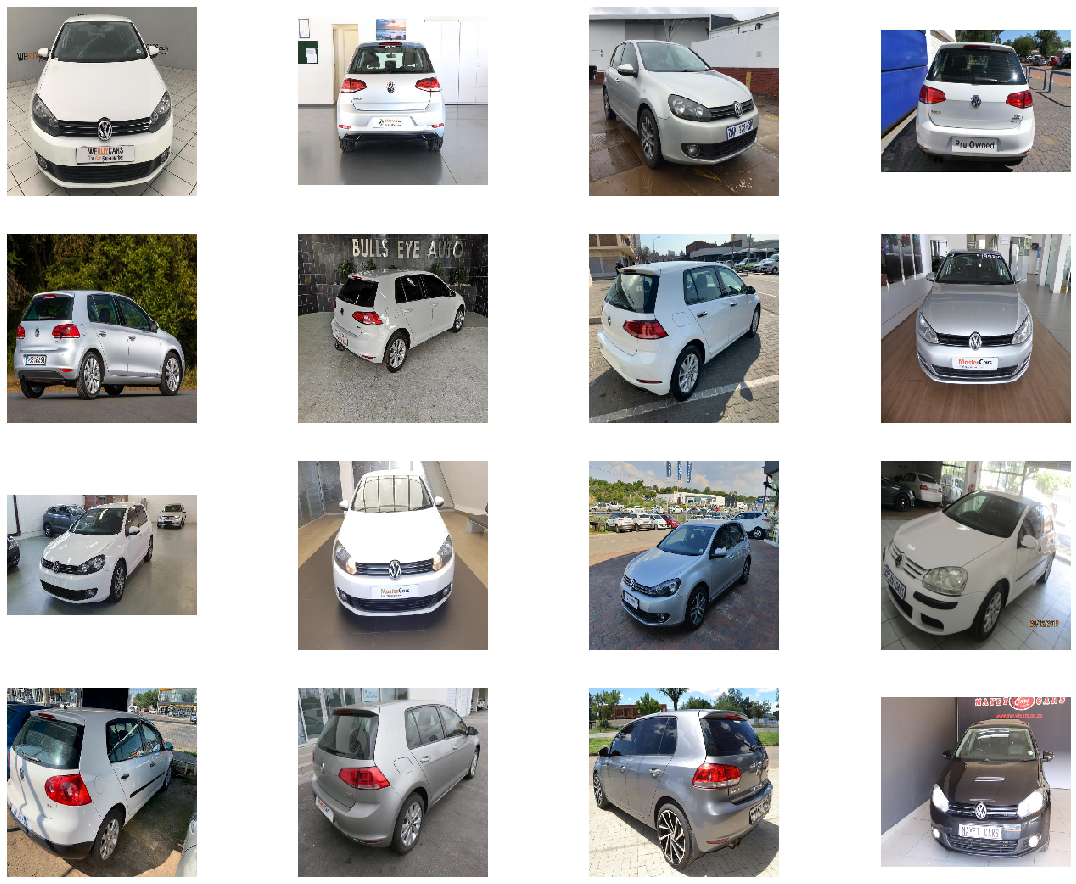

In [8]:
fig = plt.figure(figsize = (20, 16))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(img))

plt.show()

In [0]:
datagen = preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [0]:
def augment_image(image, replicates=4):
    images = [image]
    i = 1
    for batch in datagen.flow(image, batch_size=1):
        images.append(batch)
        i += 1
        if i >= replicates:
            break
    return images

In [0]:
REPLICATES = 4

In [0]:
images = [augment_image(image, REPLICATES) for image in images]

In [0]:
images = [image for sublist in images for image in sublist]

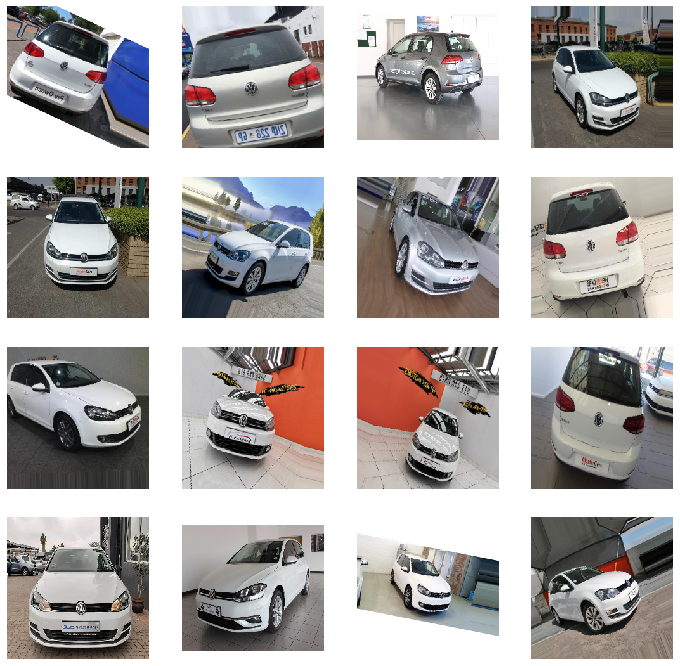

In [14]:
fig = plt.figure(figsize = (12, 12))

for i, img in zip(range(16), random.sample(images, 16)):
  fig.add_subplot(4, 4, i+1)
  plt.axis('off')
  # Transformations result in float32, so cast to uint8.
  plt.imshow(np.squeeze(img).astype('uint8'))

plt.show()

In [0]:
labez = [[label] * REPLICATES for label in labels]
labelz = np.array([label for sublist in labez for label in sublist])

In [16]:
print('Image count (after transform): {}'.format(len(images)), '\n', 'Label count (after transform): {}'.format(len(labelz)))

Image count (after transform): 952 
 Label count (after transform): 952


In [0]:
images = np.concatenate(images)

In [0]:
input_shape = images.shape[1:]

In [0]:
images = resnet.preprocess_input(images)

In [0]:
(X_train, X_test, y_train, y_test) = train_test_split(images, labelz, test_size=0.2, random_state=13)

In [0]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# Build model

In [22]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
def build_network(base, base_trainable = False):

  base.trainable = base_trainable
  model = models.Sequential()

  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(4, activation='softmax'))

  return model

In [0]:
vgg = build_network(base_model, base_trainable=True)

In [0]:
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adagrad(lr=1e-3),
    metrics=['accuracy']
)

In [0]:
BATCH_SIZE = 32
EPOCHS = 35

In [27]:
history = vgg.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 608 samples, validate on 153 samples
Epoch 1/35
608/608 [==============================] - 14s 23ms/sample - loss: 1.7875 - accuracy: 0.3668 - val_loss: 3.9349 - val_accuracy: 0.3987
Epoch 2/35
608/608 [==============================] - 5s 8ms/sample - loss: 1.1510 - accuracy: 0.5148 - val_loss: 1.4045 - val_accuracy: 0.5294
Epoch 3/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.6703 - accuracy: 0.7220 - val_loss: 0.6994 - val_accuracy: 0.7320
Epoch 4/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.5253 - accuracy: 0.7928 - val_loss: 0.8191 - val_accuracy: 0.7190
Epoch 5/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.4191 - accuracy: 0.8569 - val_loss: 0.6597 - val_accuracy: 0.7712
Epoch 6/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.2940 - accuracy: 0.9194 - val_loss: 0.4505 - val_accuracy: 0.8693
Epoch 7/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.2630 - acc

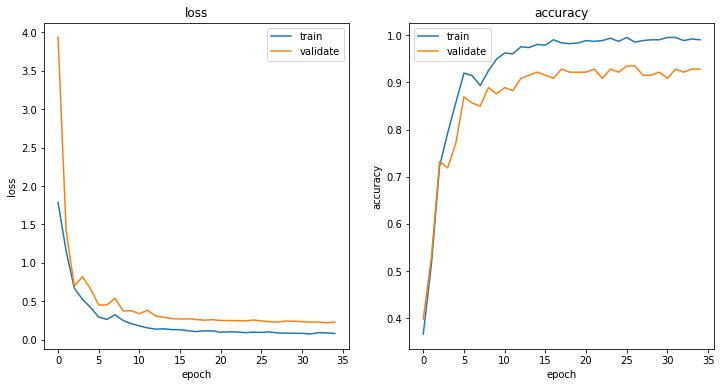

In [28]:
plot_history(history)

In [29]:
score = vgg.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 93.19% 
Test loss     = 0.223350


# Overfitting

In [0]:
loss = CategoricalCrossentropy(label_smoothing=0.1)

In [0]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg_ = build_network(base_model, base_trainable=True)

vgg_.compile(
    loss=loss,
    optimizer=optimizers.Adagrad(lr=1e-3),
    metrics=['accuracy']
)

In [0]:
EPOCHS = 35

In [33]:
history = vgg_.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split=0.2
)

Train on 608 samples, validate on 153 samples
Epoch 1/35
608/608 [==============================] - 5s 9ms/sample - loss: 1.7250 - accuracy: 0.3849 - val_loss: 2.9250 - val_accuracy: 0.5098
Epoch 2/35
608/608 [==============================] - 5s 8ms/sample - loss: 1.1020 - accuracy: 0.6020 - val_loss: 2.5093 - val_accuracy: 0.4902
Epoch 3/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.8629 - accuracy: 0.7319 - val_loss: 1.5607 - val_accuracy: 0.5686
Epoch 4/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.7896 - accuracy: 0.7730 - val_loss: 1.0607 - val_accuracy: 0.6993
Epoch 5/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.6862 - accuracy: 0.8520 - val_loss: 1.0627 - val_accuracy: 0.6993
Epoch 6/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.6443 - accuracy: 0.8799 - val_loss: 0.8858 - val_accuracy: 0.7647
Epoch 7/35
608/608 [==============================] - 5s 8ms/sample - loss: 0.6045 - accur

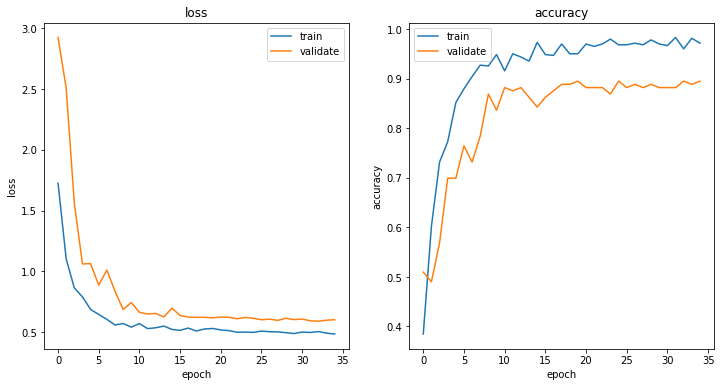

In [34]:
plot_history(history)

In [35]:
score = vgg_.evaluate(X_test, y_test, verbose=0)
print("Test accuracy = {:.2f}%".format(score[1]*100),"\nTest loss     = {:.6f}".format(score[0]))

Test accuracy = 89.53% 
Test loss     = 0.571569


Test accuracy = 87% 
Test loss     = 0.7

Test accuracy = 93.22% 
Test loss     = 0.565323

# Real world data

In [0]:
def store_image(img_url, class_type):

  filename = ''
  response = requests.get(img_url)

  if response.status_code == 200:
    directory = 'car-dataset/train/{}'.format(class_type)
    os.chdir(directory)
    filename = str(max(sorted([int(prefix.split('.')[0]) for prefix in os.listdir()])) + 1)

    with open('{}.jpg'.format(filename), 'wb') as f:
      f.write(response.content)

    os.chdir('../../..')

  return directory + '/{}.jpg'.format(filename)

In [0]:
def classify(img_url, class_type, **trained_model):
  
  filename = store_image(img_url, class_type)
  img = image.load_img(filename, target_size=(224, 224))
  plt.imshow(np.squeeze(img).astype('uint8'))

  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  for name, model in trained_model.items(): 
    golf = model.predict_classes(img)
    if (golf == 0):
      golf = '7.5'
    elif (golf == 1):
      golf = '7'
    elif (golf == 2):#se:
      golf = '6'
    else: 
      golf = 5
    print('Classifier:', name)
    print('Golf model:', golf, ', proba:', model.predict_proba(img), '\n')

## Golf 7.5

Classifier: vgg_soft_label
Golf model: 7.5 , proba: [[0.47760698 0.45468286 0.04045115 0.02725901]] 

Classifier: vgg_standard
Golf model: 5 , proba: [[0.36870432 0.09518753 0.05188724 0.4842209 ]] 



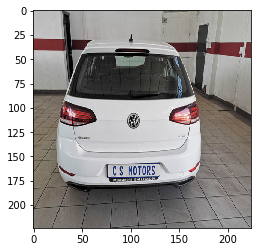

In [38]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_7.jpg?v=158700226',
    '7_5', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7.5 , proba: [[0.8533803  0.04298263 0.01032425 0.09331287]] 

Classifier: vgg_standard
Golf model: 7.5 , proba: [[0.9694624  0.0049043  0.00770606 0.01792722]] 



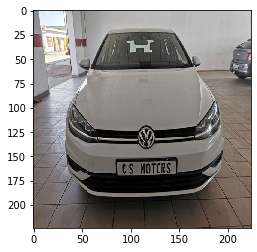

In [39]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5428529_2.jpg?v=158700226',
    '7_5', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7.5 , proba: [[0.81213176 0.06803135 0.09488939 0.02494752]] 

Classifier: vgg_standard
Golf model: 7.5 , proba: [[0.81057876 0.03162509 0.146428   0.01136824]] 



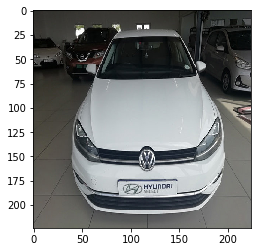

In [40]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_3.jpg?v=317154964',
    '7_5', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7 , proba: [[0.35811722 0.38893172 0.21846777 0.03448326]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[0.07229469 0.03858817 0.6677289  0.2213882 ]] 



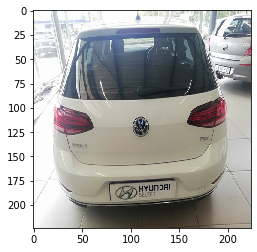

In [41]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5570873_6.jpg?v=317154964',
    '7_5', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7 , proba: [[0.04899913 0.8768107  0.05272321 0.02146687]] 

Classifier: vgg_standard
Golf model: 7 , proba: [[6.7751661e-02 9.2606318e-01 5.1627221e-04 5.6689214e-03]] 



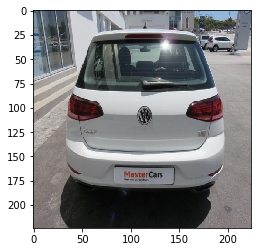

In [42]:
classify(
    'https://img.autotrader.co.za/4971493/Crop800x600',
    '7_5', vgg_soft_label = vgg_, vgg_standard = vgg
)

## Golf 7

Classifier: vgg_soft_label
Golf model: 7.5 , proba: [[0.46445423 0.04040077 0.23910232 0.2560427 ]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[0.37189397 0.06846149 0.46504346 0.09460102]] 



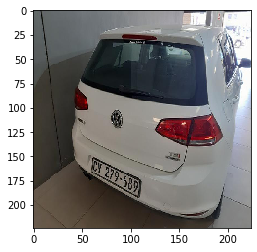

In [43]:
classify(
    'https://img.autotrader.co.za/4873898/Crop800x600',
    '7', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7 , proba: [[0.17582981 0.50070786 0.3006418  0.02282052]] 

Classifier: vgg_standard
Golf model: 7.5 , proba: [[0.53182596 0.39220273 0.04655942 0.02941193]] 



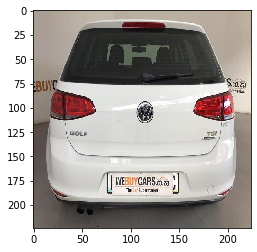

In [44]:
classify(
    'https://img.autotrader.co.za/5032958/Crop800x600',
    '7', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 7.5 , proba: [[0.43610284 0.08222305 0.40887418 0.07279994]] 

Classifier: vgg_standard
Golf model: 7.5 , proba: [[0.59157    0.00711209 0.3206487  0.08066919]] 



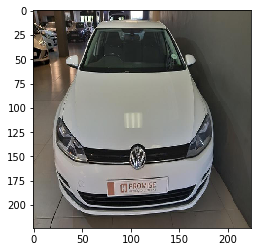

In [45]:
classify(
      'https://img.autotrader.co.za/4873896/Crop800x600',
      '7', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 6 , proba: [[0.12199567 0.19612995 0.6620498  0.0198246 ]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[0.38221958 0.05399301 0.47499126 0.08879609]] 



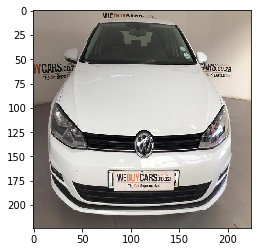

In [46]:
classify(
      'https://img.autotrader.co.za/5032960/Crop800x600',
      '7', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 6 , proba: [[0.12250063 0.24217837 0.6245422  0.01077881]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[0.01557651 0.33890462 0.6306447  0.01487415]] 



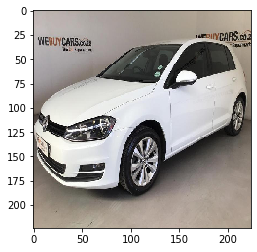

In [47]:
classify(
      'https://img.autotrader.co.za/5032957/Crop800x600',
      '7', vgg_soft_label = vgg_, vgg_standard = vgg
)

## Golf 6

Classifier: vgg_soft_label
Golf model: 6 , proba: [[8.84322682e-04 8.18239711e-03 8.90716136e-01 1.00217104e-01]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[2.1705609e-04 1.7733499e-02 6.8069744e-01 3.0135199e-01]] 



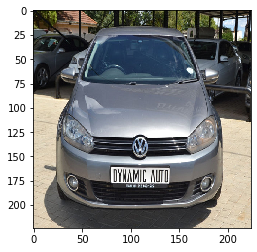

In [48]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5530306_2.jpg?v=4074465811',
    '6', vgg_soft_label = vgg_, vgg_standard = vgg
)

Classifier: vgg_soft_label
Golf model: 6 , proba: [[0.01605684 0.03867916 0.91227245 0.03299156]] 

Classifier: vgg_standard
Golf model: 6 , proba: [[9.1750885e-04 3.2919876e-02 9.4755107e-01 1.8611575e-02]] 



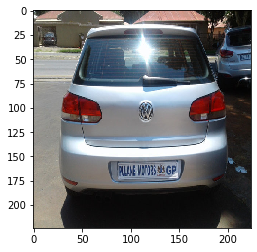

In [49]:
classify(
    'https://img-ik.cars.co.za/carsimages/tr:n-stock_med/5499518_6.jpg?v=2265708515',
    '6', vgg_soft_label = vgg_, vgg_standard = vgg
)